In [317]:
import random
import math
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, lognorm
import random as rd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
import lifelines as ll
from sklearn import tree
from sklearn import ensemble
import seaborn as sns
import sys
# import miceforest as mf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
np.random.seed(45)
random.seed(100)
np.set_printoptions(threshold=np.inf)

In [345]:
N = 10000
p = 50
censor_rate = np.array([0.4, 0.6, 0.6])
X_weight = [1/3, 1/3, 1/3]

In [377]:
X1_mean = np.random.uniform(3, 5, p).tolist()
X2_mean = np.random.uniform(0.1, 1, p).tolist()
X3_mean = np.random.uniform(0, 0.01, p).tolist()
X_Mean = [X1_mean, X2_mean, X3_mean]
X_pd_Mean = pd.DataFrame(X_Mean, index=['X_mean_1', 'X_mean_2', 'X_mean_3']).T
X1_sigma = np.random.uniform(0.1, 0.5, p).tolist()
X2_sigma = np.random.uniform(0.01, 0.1, p).tolist()
X3_sigma = np.random.uniform(0.05, 0.1, p).tolist()
X_Sigma = [X1_sigma, X2_sigma, X3_sigma]
X_pd_sigma = pd.DataFrame(X_Sigma, index=['X_sigma_1', 'X_sigma_2', 'X_sigma_3']).T
Z_x = np.random.choice(np.array([1, 2, 3]), p=X_weight, size=N)
X = np.array([multivariate_normal.rvs(X_Mean[Z_x[i]-1], X_Sigma[Z_x[i]-1], random_state=i) for i in range(N)])
X_name = [f'x_{i+1}' for i in range(p)]
data_X = pd.DataFrame(X, columns=X_name)
data_X.to_csv('Partial coefficients.csv')

In [425]:
x1 = X[:,0]
X_M = np.array([3, 0.1, 0])
weight_func = np.array([np.exp(-(x1[j]-X_M)**2) for j in range(N)])
print(weight_func.sum(axis=1).reshape(-1,1).shape)
weight = weight_func/weight_func.sum(axis=1).reshape(-1,1)
Z_y = np.array([np.random.choice(np.array([1, 2, 3]), p=weight[i,:]) for i in range(N)])
# all_PD = pd.concat([X_pd_Mean, X_pd_sigma, beta_mean], axis=1, ignore_index=True)
# all_PD.to_csv('Partial coefficients.csv')
print(np.sum(Z_y == 1), np.sum(Z_y == 2), np.sum(Z_y == 3))

(10000, 1)
3245 3420 3335


In [459]:
np.random.seed(40)
beta1 = np.random.uniform(0.02, 0.05, p)/1.5
beta2 = np.ones(p)/10
beta3 = np.random.uniform(0.5, 1, p)/5
beta = [beta1, beta2, beta3]
beta_mean = pd.DataFrame(beta, index=['beta_mean_1', 'beta_mean_2', 'beta_mean_3']).T
Y1_sigma = 0.01
Y2_sigma = 0.05
Y3_sigma = 0.25
Y_Sigma = [Y1_sigma, Y2_sigma, Y3_sigma]
N_y = np.unique(Z_y, return_counts=True)[1]
C_y = censor_rate * N_y
C_y = C_y.astype(int)
C_y_0 = [np.zeros(C_y[i]) for i in range(3)]
C_y_1 = [np.ones(N_y[i] - C_y[i]) for i in range(3)]
C_y = [np.concatenate((C_y_0[i], C_y_1[i])) for i in range(3)]
data_X['z_x'] = Z_x
data_Y = data_X.copy()
data_Y['z_y'] = Z_y
data_Y['c_y'] = np.ones(data_Y.shape[0])
data_Y['y_mu'] = np.array([sum(X[i]*beta[Z_y[i]-1]) for i in range(N)])
data_Y['y_sigma'] = np.ones(data_Y.shape[0])
data_Y['Y'] = np.ones(data_Y.shape[0])
for i in range(3):
    ind_c_y_group = data_Y[data_Y['z_y'] == i+1].index
    data_Y.loc[data_Y['z_y'] == i+1, 'y_sigma'] = Y_Sigma[i]
    ind_c_y_group_0 = ind_c_y_group[0:len(C_y_0[i])]
    data_Y.loc[ind_c_y_group_0, 'c_y'] = 0
print((data_Y['y_mu']>3).sum(), data_Y['y_mu'].max())

4964 4.994292116409144


In [460]:
for i in range(N):
    dist = lognorm(s=data_Y.loc[i, 'y_sigma'], scale=math.exp(data_Y.loc[i, 'y_mu']))
    if data_Y.loc[i,'c_y'] == 0:
        np.random.seed(365+i)
        p0 = np.random.uniform(0,1)
        data_Y.loc[i,'Y'] = dist.isf(p0)
    else:
        data_Y.loc[i,'Y'] = dist.rvs(size=1, random_state=365+i)

In [461]:
print(data_Y['Y'].max())


194.43961850385574


In [464]:
data_Y.to_csv('Simulated Full Data.csv')
beta_mean.to_csv('Simulation Parameters.csv')

<function matplotlib.pyplot.show(close=None, block=None)>

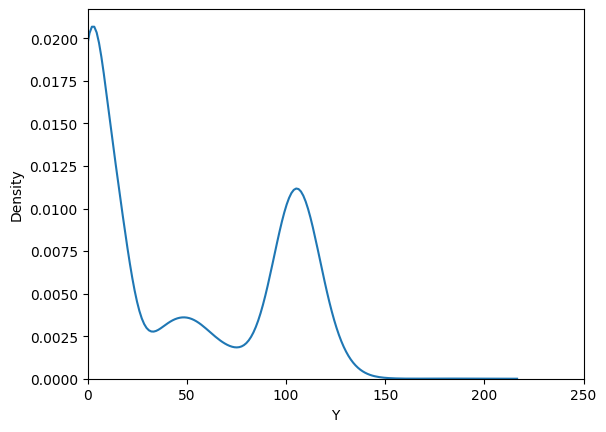

In [463]:
fig = sns.kdeplot(data=data_Y, x='Y')
plt.xlim(0,250)
plt.show